In [ ]:
!pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import subprocess
try:
    import leafmap
except ImportError:
    print('Installing leafmap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'leafmap'])

In [ ]:
import leafmap
import geopandas as gpd
import pandas as pd

In [ ]:
sa1 = gpd.read_file("/content/drive/MyDrive/lst/sa1/SA1_2016_AUST.shp")

In [ ]:
sa1['SA1_MAIN16'] = sa1['SA1_MAIN16'].astype('int64')
# sa1_in_climate = sa1_in_climate.set_index('SA1_MAIN16')

In [ ]:
lst2016 = pd.read_csv("/content/drive/MyDrive/lst/sa1_lst/lst_2016.csv")

In [ ]:
lst2016['date'] = lst2016['date'].astype( 'datetime64[ns]')

In [ ]:
lst2016_summer = lst2016[(lst2016.date < pd.Timestamp(2016,3,1)) | (lst2016.date >= pd.Timestamp(2016,12,1))]


# Heat wave defination

### Excess heat indecies (EHI)
Nairn, John R., and Robert JB Fawcett. "The excess heat factor: a metric for heatwave intensity and its use in classifying heatwave severity." International journal of environmental research and public health 12.1 (2015): 227-253.

### Significance index

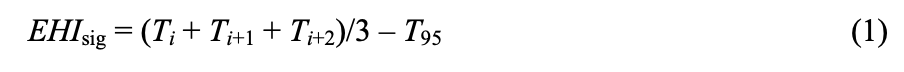

In [ ]:
T95 = lst2016_summer[['SA1_MAIN16','mean']].groupby('SA1_MAIN16').quantile(.95)

In [ ]:
T95 = T95.reset_index(0)

In [ ]:
sorted_lst2016 = lst2016.sort_values(['SA1_MAIN16','date'],ascending=[False,False])
sorted_lst2016['avg_3_day'] = sorted_lst2016.groupby('SA1_MAIN16',sort=False)['mean'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)

In [ ]:
T95 =T95.set_index('SA1_MAIN16').rename({'mean':'T95'},axis=1)

In [ ]:
result = sorted_lst2016.set_index('SA1_MAIN16').join(T95,how='inner')

In [ ]:
result['sig'] = result['avg_3_day'] - result['T95']

### Acclimatisation index

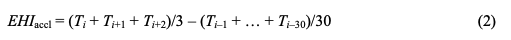

In [ ]:
result = result.sort_values(['SA1_MAIN16','date'])
result['avg_30_day'] = result.groupby('SA1_MAIN16',sort=False)['mean'].rolling(30, min_periods=1).mean().reset_index(0, drop=True)

In [ ]:
result['accl'] = result['avg_3_day'] - result['avg_30_day']

### Excess Heat Factor

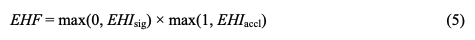

In [ ]:
import numpy as np
result['EHF'] = np.maximum(0,result['sig']) * np.maximum(1,result['accl'])

In [ ]:
EHF_summer = result[(result.date < pd.Timestamp(2016,3,1)) | (result.date >= pd.Timestamp(2016,12,1))]

## Plot annual summary

In [ ]:
EHF_annual = EHF_summer.groupby(EHF_summer.index)['EHF'].sum().reset_index()

In [ ]:
region_geoms = sa1[['SA1_MAIN16','geometry']]
region_geoms['SA1_MAIN16'] = region_geoms['SA1_MAIN16'].astype('int64')

In [ ]:
EHF_spatial  = region_geoms.set_index('SA1_MAIN16').join(EHF_annual.set_index('SA1_MAIN16'),how='inner')

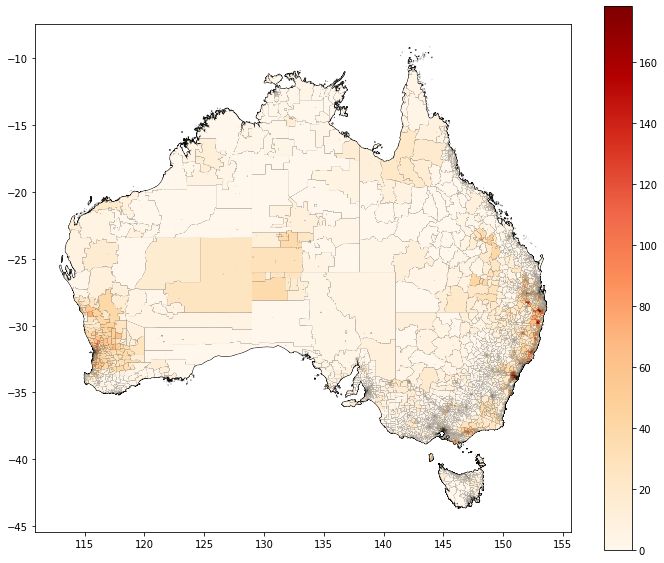

In [ ]:
base = EHF_spatial.plot(color='white', edgecolor='black',figsize=(12,10))
EHF_spatial.plot(ax=base, column='EHF',legend=True,cmap='OrRd')

### Export to google drive

In [ ]:
def generate_EHF(year):
  lst = pd.read_csv("/content/drive/MyDrive/lst/lst_{}.csv".format(year))
  lst['date'] = lst['date'].astype( 'datetime64[ns]')
  lst_summer = lst[(lst.date < pd.Timestamp(year,3,1)) | (lst.date >= pd.Timestamp(year,12,1))]
  T95 = lst_summer[['SA1_MAIN16','mean']].groupby('SA1_MAIN16').quantile(.95).reset_index()
  T95 = T95.rename({'mean':'T95'},axis=1).set_index('SA1_MAIN16')
  sorted_lst = lst.sort_values(['SA1_MAIN16','date'],ascending=[False,False])
  sorted_lst['avg_3_day'] = sorted_lst.groupby('SA1_MAIN16',sort=False)['mean'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
  result = sorted_lst.set_index('SA1_MAIN16').join(T95,how='inner')
  result['sig'] = result['avg_3_day'] - result['T95']
  result = result.sort_values(['SA1_MAIN16','date'])
  result['avg_30_day'] = result.groupby('SA1_MAIN16',sort=False)['mean'].rolling(30, min_periods=1).mean().reset_index(0, drop=True)
  result['accl'] = result['avg_3_day'] - result['avg_30_day']
  result['EHF'+str(year)] = np.maximum(0,result['sig']) * np.maximum(1,result['accl'])
  EHF_summer = result[(result.date < pd.Timestamp(year,3,1)) | (result.date >= pd.Timestamp(year,12,1))]
  EHF_annual = EHF_summer.groupby(EHF_summer.index)['EHF'+str(year)].sum().reset_index().set_index('SA1_MAIN16')
  return EHF_annual

In [ ]:
import numpy as np

region_geoms = sa1[['SA1_MAIN16','geometry']]
region_geoms['SA1_MAIN16'] = region_geoms['SA1_MAIN16'].astype('int64')
region_geoms = region_geoms.set_index('SA1_MAIN16')
years = [2016,2017,2018,2019,2020]
for year in years:
  EHF = generate_EHF(year)
  region_geoms = region_geoms.join(EHF,how='inner')


In [ ]:
value_set = region_geoms['EHF2016'].tolist() + region_geoms['EHF2017'].tolist() + region_geoms['EHF2018'].tolist() + region_geoms['EHF2019'].tolist() + region_geoms['EHF2020'].tolist()
vmin = min(value_set)
vmax = max(value_set)
print(vmin)
print(vmax)

0.0
234.93385470116243


In [ ]:
region_geoms.to_file("/content/drive/MyDrive/lst/EHF/ehf_original.shp")

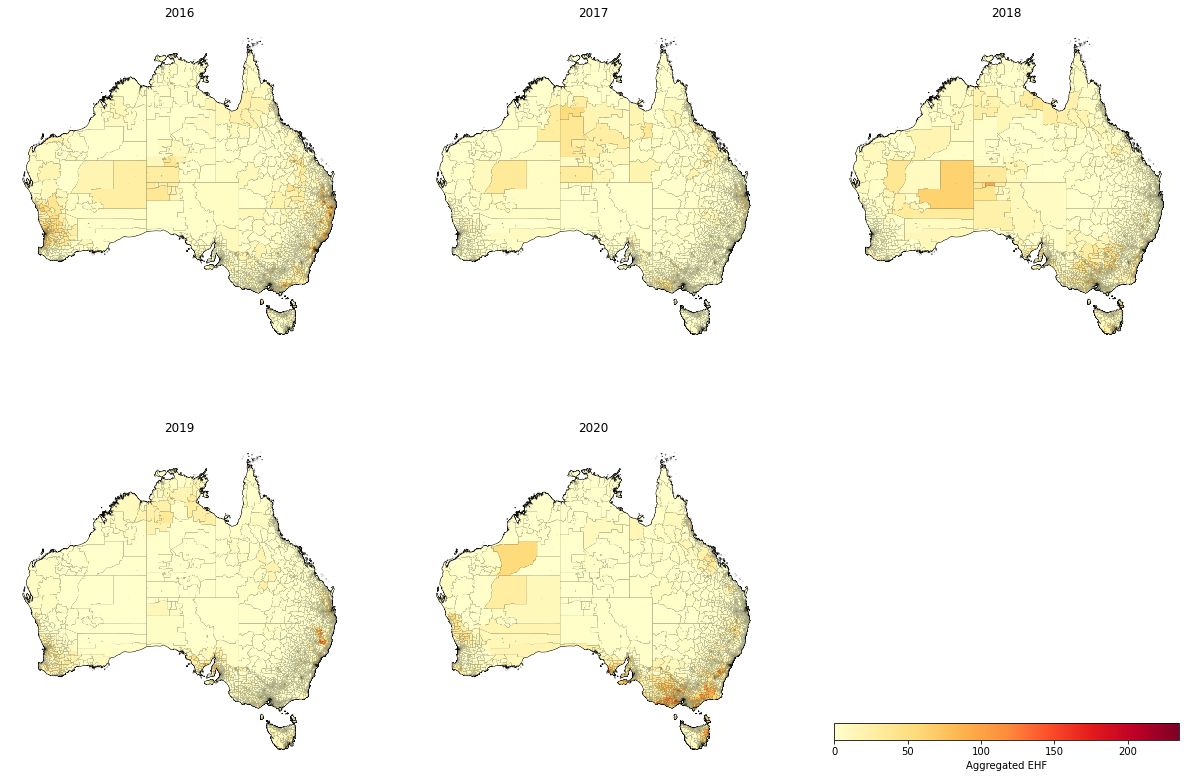

In [ ]:
import matplotlib as m
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 3, figsize=(21, 14))
axs = axs.flatten()

for ax in axs:
  ax.axis("off")

for idx in range(len(years)):
  base = region_geoms.plot(ax=axs[idx], color='white', edgecolor='black')
  region_geoms.plot(ax=base,cmap='YlOrRd',column = 'EHF'+str(years[idx]), vmin=vmin, vmax=vmax)
  base.set_title(str(years[idx]))

norm = m.colors.Normalize(vmin=vmin,vmax=vmax)
plt.colorbar(m.cm.ScalarMappable(norm=norm, cmap="YlOrRd"),ax=axs[-1], orientation='horizontal', label="Aggregated EHF")
plt.show()